In [1]:
import pandas as pd
from src import *
import joblib

Class Distribution:
 Status
Normal                  11264
Depression              10635
Suicidal                 7452
Anxiety                  2586
Bipolar                  1801
Stress                   1680
Personality disorder      662
Name: count, dtype: int64


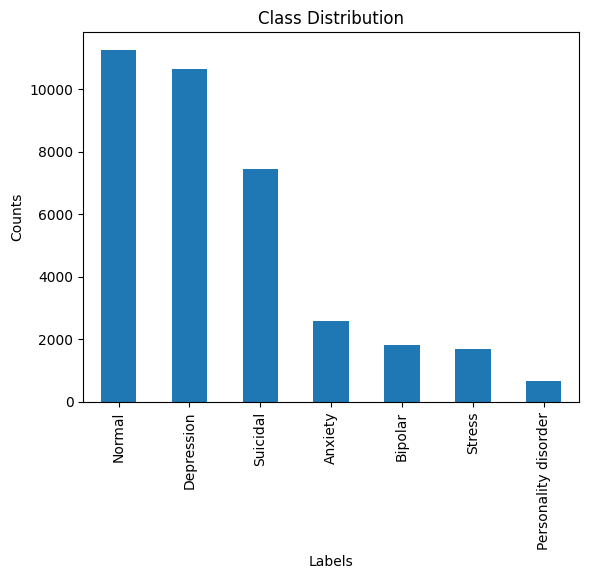

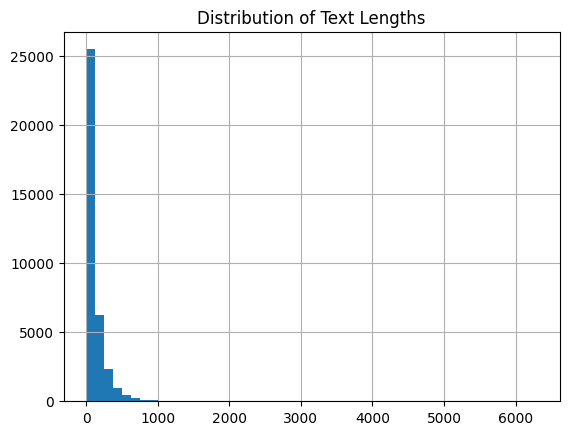

In [2]:
#Load Data and drop nulls
df = load_data("data/Sentiment_analysis_dataset.csv")
df = clean_data(df)
check_class_distribution(df)
df = add_text_length(df)
check_text_length_distribution(df)
    

None


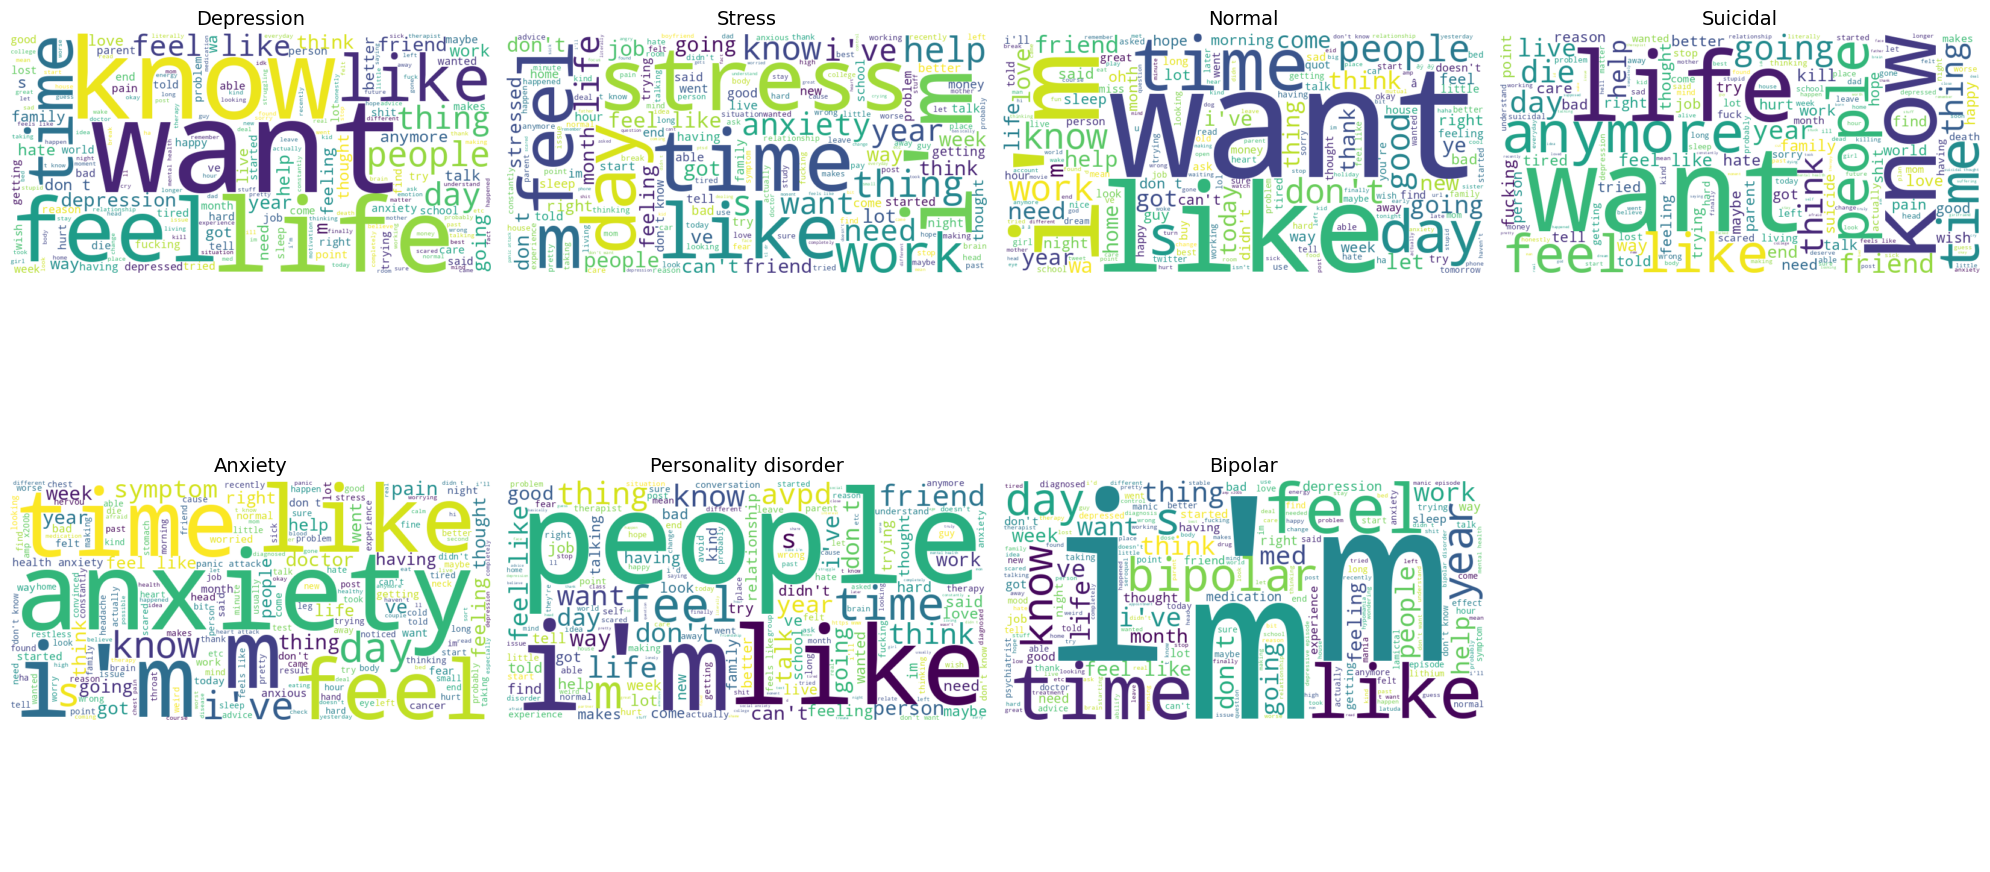

In [5]:
# Clean text

if not os.path.exists("clean_df.pkl"):
    df['CleanText'] = df['Statement'].apply(preprocess)
    joblib.dump(df, "clean_df.pkl")
else:
    df = joblib.load("clean_df.pkl")
    
if not os.path.exists("word_freq.pkl"):
    freq_data = get_clean_word_freq(df)
    joblib.dump(freq_data, "word_freq.pkl")
else:
    freq_data = joblib.load("word_freq.pkl")
    print(freq_data)
    
visualize_word_clouds(df)


In [6]:
# # Extract features
X_tfidf, tfidf = extract_features(df)
y, le = encode_labels(df)
    
# # Split data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_tfidf, y)
    
# # # Handle class imbalance
X_train_resampled, y_train_resampled = handle_imbalance(X_train, y_train)


Train size: 28864 | Val: 3608 | Test: 3608


Validation Accuracy: 0.6978935698447893
                      precision    recall  f1-score   support

             Anxiety       0.71      0.76      0.74       258
             Bipolar       0.71      0.74      0.72       180
          Depression       0.73      0.59      0.66      1064
              Normal       0.88      0.82      0.85      1126
Personality disorder       0.38      0.58      0.46        67
              Stress       0.28      0.54      0.37       168
            Suicidal       0.62      0.68      0.65       745

            accuracy                           0.70      3608
           macro avg       0.62      0.67      0.63      3608
        weighted avg       0.73      0.70      0.71      3608

Evaluation report saved as validation_evaluation_reports/LogisticRegression_validation_evaluation_report.csv
Confusion matrix saved as confusion_matrices\LogisticRegression_confusion_matrix.png


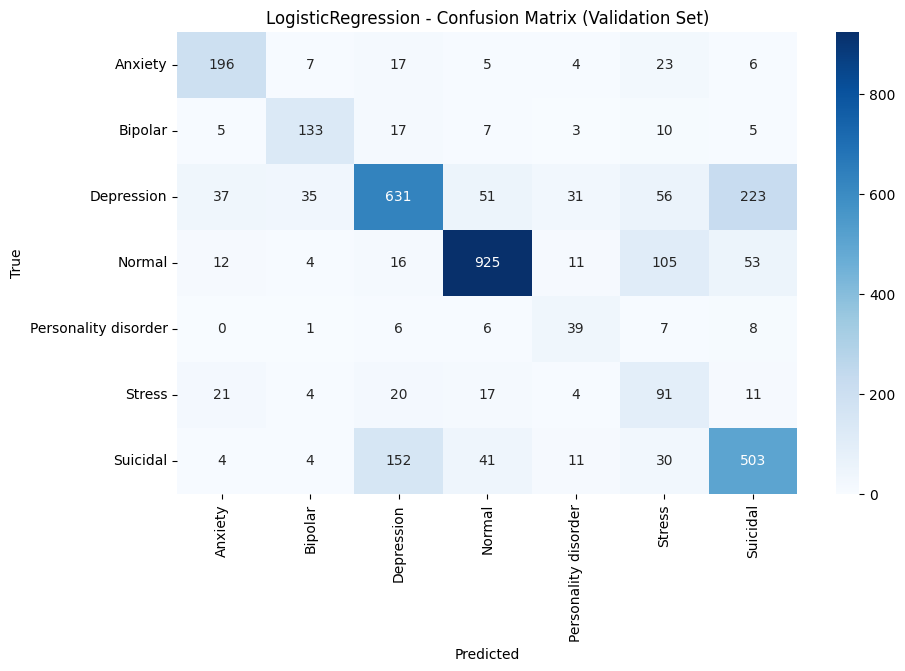

Model saved as models\LogisticRegression.pkl


In [7]:
# Train Logistic regression model
lr_model = train_lr_model(X_train_resampled, y_train_resampled)
    
# Evaluate model
evaluate_model(lr_model, X_val, y_val, le)
    
# Save model
save_model(lr_model)

Validation Accuracy: 0.7012195121951219
                      precision    recall  f1-score   support

             Anxiety       0.72      0.72      0.72       258
             Bipolar       0.71      0.68      0.70       180
          Depression       0.63      0.65      0.64      1064
              Normal       0.84      0.92      0.88      1126
Personality disorder       0.72      0.31      0.44        67
              Stress       0.50      0.21      0.29       168
            Suicidal       0.59      0.59      0.59       745

            accuracy                           0.70      3608
           macro avg       0.67      0.58      0.61      3608
        weighted avg       0.69      0.70      0.69      3608

Evaluation report saved as validation_evaluation_reports/RandomForestClassifier_validation_evaluation_report.csv
Confusion matrix saved as confusion_matrices\RandomForestClassifier_confusion_matrix.png


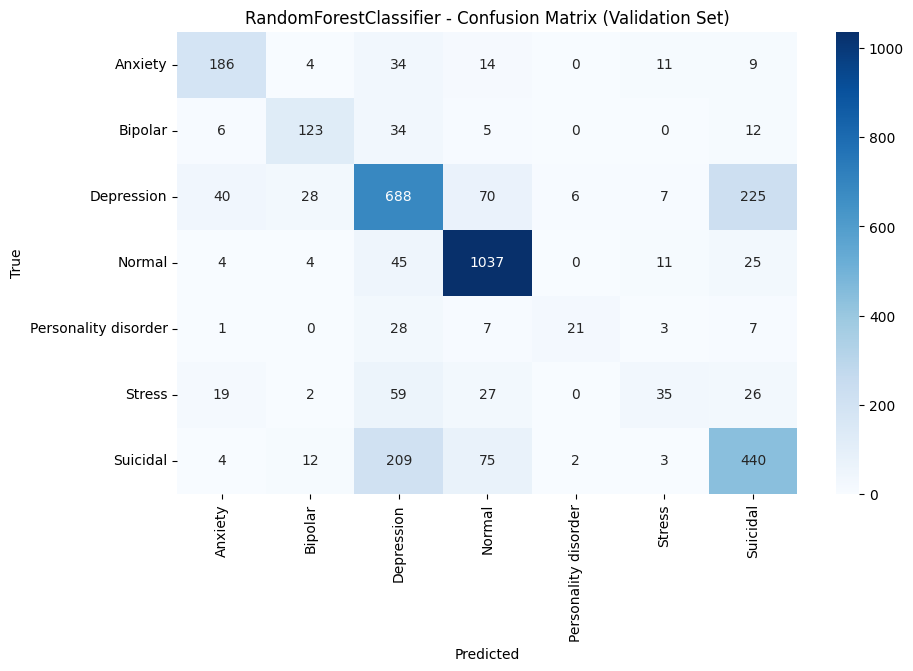

Model saved as models\RandomForestClassifier.pkl


In [8]:
#train random forest model
rf_model = train_rf_model(X_train_resampled, y_train_resampled)

evaluate_model(rf_model, X_val, y_val, le)

save_model(rf_model)

In [ ]:
#train naive bayes model
nb_model = train_nb_model(X_train_resampled, y_train_resampled)

evaluate_model(nb_model, X_val, y_val, le)

save_model(nb_model)

In [ ]:
#train neural network
cnn_model = train_cnn_model(X_train_resampled, y_train_resampled, X_val, y_val, y_test)

evaluate_model(cnn_model, X_val, y_val, le)

save_model(cnn_model)

In [ ]:
#train xgboost model
xgb_model = train_xgb_model((X_train_resampled, y_train_resampled)
                            
evaluate_model(cnn_model, X_val, y_val, le)

save_model(cnn_model)

In [ ]:
#saving the dataset
df.to_csv("data/cleaned_sentiment_dataset.csv", index=False)